# Non-linear Matrix Factorization with Gaussian Processes

This is an attempt to reproduce [this ICML 2009 paper](http://people.ee.duke.edu/~lcarin/MatrixFactorization.pdf).

In [1]:
import tensorflow as tf
DEVICE = "/cpu:0"

In [8]:
from collections import Counter

In [11]:
N = 100  # items
D = 2071  # users
q = 10  # latent dimension

In [12]:
# Simulated data
import numpy as np
from sklearn.preprocessing import scale

def get_simulated_data(true_alpha_x=5, true_alpha_w=2, true_sigma=1):
    X = np.random.randint(50, size=(N, q))
    #X = np.random.normal(0, 1/true_alpha_x, (N, q))
    W = np.random.normal(0, 1/true_alpha_w, (D, q))
    rating_rows = []
    for i in range(N):
        rating_rows.append(np.random.multivariate_normal(W.dot(X[i, :]), true_sigma ** 2 * np.eye(D)))
    Y = np.array(rating_rows)
    Y_scaled = scale(Y, axis=1, with_std=False)
    return Y, Y_scaled

In [13]:
rating_values = {'dislike': 1, 'wontsee': 2, 'neutral': 3, 'willsee': 4, 'like': 5, 'favorite': 6}

In [14]:
# Real data
from mangaki.algo.dataset import Dataset
#from mangaki.utils.values import rating_values

dataset = Dataset()
dataset.load_csv('ratings-ordered.csv', convert=lambda choice: rating_values[choice])

In [15]:
from scipy.sparse import coo_matrix

rows = dataset.anonymized.X[:, 0]
cols = dataset.anonymized.X[:, 1]
data = dataset.anonymized.y
mangaki = coo_matrix((data, (rows, cols)), shape=(dataset.anonymized.nb_users, dataset.anonymized.nb_works)).tocsr()

In [16]:
from collections import defaultdict

inverter = defaultdict(list)
for user_id in range(D):
    batch = mangaki[user_id, :]
    c = Counter(batch.data)
    inverter[tuple(c[rating_values[rating]] for rating in ['dislike', 'favorite', 'like', 'neutral', 'willsee', 'wontsee'])].append(user_id)

In [17]:
inverter[16, 23, 118, 9, 330, 68]

[162]

In [18]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

Now skip to ALS.

In [132]:
mangaki[:, :100]

<2071x100 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [133]:
Y = mangaki[:, :100].tocoo().T.tocsr()
for movie_id in range(N):
    row = Y[movie_id, :]
    for user_id, replace in zip(row.indices, scale(row.data)):
        Y[movie_id, user_id] = replace

In [134]:
dataset = coo_matrix(Y)
#dataset = coo_matrix(Y_scaled)

In [135]:
Y

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [136]:
# Prepare batches
from sklearn.model_selection import ShuffleSplit

# Simple split
splitter = ShuffleSplit(n_splits=1, test_size=0.2)
for i_train, i_test in splitter.split(dataset.data):
    train = coo_matrix((dataset.data[i_train], (dataset.row[i_train], dataset.col[i_train])), shape=(N, D)).tocsc()
    test = coo_matrix((dataset.data[i_test], (dataset.row[i_test], dataset.col[i_test])), shape=(N, D)).tocsc()

# Split by user
train_data = []
train_row = []
train_col = []
test_data = []
test_row = []
test_col = []
full = dataset.tocsc()
nb_skip = 0
train_users = set(range(D))
for user_id in range(D):
    this_user = full[:, user_id]
    N_j = this_user.getnnz()
    if N_j <= q:
        train_users.remove(user_id)
        nb_skip += 1
        continue
    for i_train, i_test in splitter.split(this_user.indices):
        train_col.extend([user_id] * len(i_train))
        train_row.extend(this_user.indices[i_train])
        train_data.extend(this_user.data[i_train])
        test_col.extend([user_id] * len(i_test))
        test_row.extend(this_user.indices[i_test])
        test_data.extend(this_user.data[i_test])
print('nb users skipped', nb_skip, 'over', D)

nb users skipped 465 over 2071


In [137]:
assert len(train_data) == len(train_row)
assert len(test_data) == len(test_row)

In [138]:
train = coo_matrix((train_data, (train_row, train_col)), shape=(N, D)).tocsc()
test = coo_matrix((test_data, (test_row, test_col)), shape=(N, D)).tocsc()

In [139]:
train

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 60093 stored elements in Compressed Sparse Column format>

In [140]:
test

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 15842 stored elements in Compressed Sparse Column format>

In [141]:
item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
rate_batch = tf.placeholder(tf.float32, shape=[None, None], name="rate")
pred_batch = tf.placeholder(tf.int32, shape=[None], name="id_pred")

In [142]:
def log_det(cov):
    return 2 * tf.reduce_sum(tf.log(tf.diag_part(tf.cholesky(cov))))

In [146]:
def kernel(X, Y):
    return tf.matmul(X, tf.transpose(Y))

class MFGP:
    def __init__(self):
        with tf.device(DEVICE):
            with tf.variable_scope("conv1"):
                self.sigma = tf.Variable(1e-1, name="sigma")  # tf.random_normal([1])
                self.alpha_w = tf.Variable(tf.random_normal([1]), name="alpha_w")
                self.X_item = tf.Variable(tf.random_normal([N, q], stddev=5), name="embd_item")

    def predict(self, item_batch, rate_batch, pred_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            X_pred = tf.nn.embedding_lookup(self.X_item, pred_batch)
            N_j = tf.shape(item_batch)[0]
            cov = kernel(X_batch, X_batch) + self.sigma ** 2 * tf.eye(N_j)
            s = tf.matmul(tf.matrix_inverse(cov), kernel(X_batch, X_pred))
            prediction = tf.matmul(tf.transpose(s), rate_batch)
        return tf.reshape(prediction, [-1])

    def get_loss(self, item_batch, rate_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            XT_batch = tf.transpose(X_batch)
            N_j = tf.shape(item_batch)[0]
            defpos = kernel(X_batch, X_batch)
            cov = 1/tf.abs(self.alpha_w) * defpos + self.sigma ** 2 * tf.eye(N_j)
            # inv_cov = tf.matrix_inverse(cov)  # O(N_j^3)
            cheap_inv = tf.matrix_inverse(tf.abs(self.alpha_w) * self.sigma ** (-2) * tf.eye(q)
                                          + tf.matmul(XT_batch, X_batch))
            inv_cov = self.sigma ** (-2) - self.sigma ** (-4) * tf.matmul(X_batch, tf.matmul(cheap_inv, XT_batch))  # O(q^3)
            loss = (tf.cast(N_j, tf.float32) * log_det(cov)
                    + tf.reshape(tf.matmul(tf.transpose(rate_batch), tf.matmul(inv_cov, rate_batch)), []))
        return loss, (cov, defpos, X_batch)

    def optimization(self, item_batch, rate_batch, learning_rate):
        global_step = tf.train.get_global_step()
        assert global_step is not None
        with tf.device(DEVICE):
            loss, (cov, defpos, X_batch) = self.get_loss(item_batch, rate_batch)
            train_op = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step=global_step, var_list=[self.X_item])
        return loss, train_op, (cov, defpos, X_batch)

In [147]:
def to_matrix(l):
    return np.array(l).reshape(len(l), 1)

In [148]:
from sklearn.metrics import mean_squared_error
from collections import deque
import time
import random
import sys

mfgp = MFGP()
prediction = mfgp.predict(item_batch, rate_batch, pred_batch)

global_step = tf.contrib.framework.get_or_create_global_step()
loss, train_op, (cov, defpos, X_batch) = mfgp.optimization(item_batch, rate_batch, learning_rate=0.0001)

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(" | ".join(["user_id", "epoch", "train_error", "val_error", "elapsed_time"]))
    errors = []
    for epoch in range(50):
        cross = list(train_users)
        random.shuffle(cross)
        train_preds = []
        train_ratings = []
        for user_id in cross:
            train_batch = train[:, user_id]
            if train_batch.getnnz() == 0:
                continue
            items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
            try:
                sess.run(train_op, feed_dict={item_batch: items_rated,
                                              rate_batch: ratings,
                                              pred_batch: items_rated})
            except Exception as e:
                print('Error for %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                print('Sigma', mfgp.sigma.eval(), 'alpha_w', mfgp.alpha_w.eval())
                print(sess.run([tf.shape(X_batch), X_batch], feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(defpos), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(cov), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(e.message)
                print(sys.exc_info()[0].__doc__)

        # End of train epoch, start test
        if epoch % 1 == 0:
            total_nll = []
            test_truth = []
            test_preds = []
            for user_id in train_users:
                train_batch = train[:, user_id]
                test_batch = test[:, user_id]
                items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
                items_to_pred, truth = test_batch.indices, test_batch.data
                try:
                    this_user_nll, train_pred = sess.run([loss, prediction], feed_dict={item_batch: items_rated,
                                                                                        rate_batch: ratings,
                                                                                        pred_batch: items_rated})
                except:
                    print('Error for train %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                try:
                    test_pred = sess.run(prediction, feed_dict={item_batch: items_rated,
                                                                rate_batch: ratings,
                                                                pred_batch: items_to_pred})
                except:
                    print('Error for test %d (%s): %s' % (user_id, str(items_to_pred), sys.exc_info()[0]))
                total_nll.append(this_user_nll)
                train_ratings.extend(ratings)
                train_preds.extend(train_pred)
                test_truth.extend(truth)
                test_preds.extend(test_pred)
            train_rmse = np.sqrt(mean_squared_error(train_ratings, train_preds))            
            train_stupid = np.sqrt(mean_squared_error(train_ratings, [0] * len(train_ratings)))            
            test_rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
            test_stupid = np.sqrt(mean_squared_error(test_truth, [0] * len(test_truth)))
            print("epoch={:3d} train_rmse={:f} ({:f}) test_rmse={:f} ({:f}) total_nll={:f} sigma={:f} alpha_w={:f}"
                  .format(epoch, train_rmse, train_stupid, test_rmse, test_stupid,
                          sum(total_nll), abs(float(mfgp.sigma.eval())), abs(float(mfgp.alpha_w.eval()))))
    print('learned sigma')
    print(mfgp.sigma.eval())
    print('learned alpha_w')
    print(mfgp.alpha_w.eval())
    print('learned x')
    print(mfgp.x_item.eval())

user_id | epoch | train_error | val_error | elapsed_time
epoch=  0 train_rmse=7.099235 (1.000710) test_rmse=6.157351 (1.003259) total_nll=-287224265.353516 sigma=0.100000 alpha_w=1.753959
epoch=  1 train_rmse=2.079178 (1.000710) test_rmse=2.118881 (1.003259) total_nll=-298726846.699219 sigma=0.100000 alpha_w=1.753959
epoch=  2 train_rmse=11.680286 (1.000710) test_rmse=9.852969 (1.003259) total_nll=-302750440.118164 sigma=0.100000 alpha_w=1.753959
epoch=  3 train_rmse=19.395447 (1.000710) test_rmse=15.919051 (1.003259) total_nll=-304895133.985352 sigma=0.100000 alpha_w=1.753959
epoch=  4 train_rmse=27.530071 (1.000710) test_rmse=28.348537 (1.003259) total_nll=-306099596.312500 sigma=0.100000 alpha_w=1.753959
epoch=  5 train_rmse=9.603479 (1.000710) test_rmse=9.229228 (1.003259) total_nll=-307085520.960938 sigma=0.100000 alpha_w=1.753959


KeyboardInterrupt: 

(The error is because it was interrupted.)

As you can see, the learning stops when the stupid RMSE (every prediction is 0) is obtained.

# Meanwhile, Alternating Least Squares…

In [11]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

In [12]:
mangaki.data[:10]

array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  5.,  3.])

In [13]:
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1, test_size=0.2)
X_train = []
y_train = []
X_test = []
y_test = []
for i_train, i_test in splitter.split(range(D)):
    i_train = set(i_train)
    i_test = set(i_test)
    for (user_id, work_id), rating in zip(dataset.anonymized.X, dataset.anonymized.y):
        if user_id in i_train:
            X_train.append((user_id, work_id))
            y_train.append(rating)
        else:
            X_test.append((user_id, work_id))
            y_test.append(rating)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [14]:
len(X_train), len(X_test)

(271963, 61684)

In [15]:
from mangaki.algo.als import MangakiALS

def compute_all_errors(X_train, y_train, X_test, y_test):
    y_train_pred = als.predict(X_train)
    print('Train RMSE=', als.compute_rmse(y_train, y_train_pred))
    y_test_pred = als.predict(X_test)
    print('Test RMSE=', als.compute_rmse(y_test, y_test_pred))

als = MangakiALS()
als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
als.fit(X_train, y_train)
compute_all_errors(X_train, y_train, X_test, y_test)

Computing M: (2071 × 10086)
Chrono: fill and center matrix [0q, 858ms]
Shapes (2071, 20) (20, 10086)
Chrono: factor matrix [0q, 6601ms]
Train RMSE= 0.908271075216
Test RMSE= 3.87582836308


In [16]:
y_pred = als.predict(X_train)
(y_train - y_pred).std()

0.9082097014276056

And the learned rows of $U$ seem Gaussian!

(array([   5.,   23.,   72.,  186.,  412.,  668.,  357.,  212.,  117.,   19.]),
 array([-1.40553287, -1.1416685 , -0.87780414, -0.61393978, -0.35007541,
        -0.08621105,  0.17765332,  0.44151768,  0.70538205,  0.96924641,
         1.23311077]),
 <a list of 10 Patch objects>)

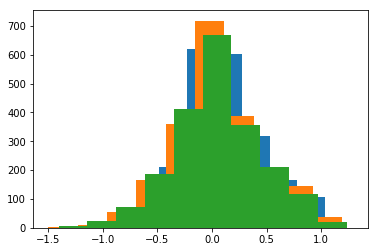

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.U[:, 0])
plt.hist(als.U[:, 1])
plt.hist(als.U[:, 15])

(array([  6.20000000e+01,   3.07000000e+02,   1.04700000e+03,
          3.46700000e+03,   3.79700000e+03,   1.01200000e+03,
          3.08000000e+02,   7.50000000e+01,   9.00000000e+00,
          2.00000000e+00]),
 array([-1.12514553, -0.83165082, -0.53815612, -0.24466141,  0.0488333 ,
         0.342328  ,  0.63582271,  0.92931742,  1.22281212,  1.51630683,
         1.80980154]),
 <a list of 10 Patch objects>)

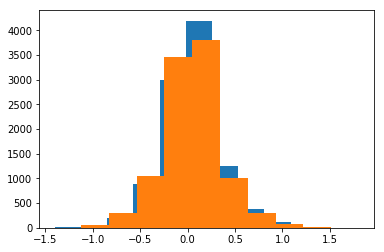

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.VT.T[:, 17])
plt.hist(als.VT.T[:, 5])

Maybe it does not hold for $V$.

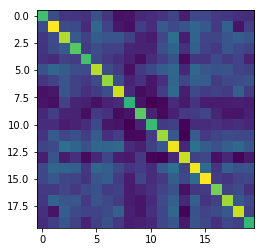

In [19]:
%matplotlib inline

cov = np.cov(als.U.T)
plt.imshow(cov)

In [20]:
np.diag(cov)

array([ 0.11525583,  0.15841233,  0.14159525,  0.12137024,  0.11636359,
        0.14328949,  0.13612286,  0.14800439,  0.10878458,  0.1228831 ,
        0.11313073,  0.1370391 ,  0.1545922 ,  0.14627613,  0.15608236,
        0.15818078,  0.12874093,  0.13833517,  0.14749259,  0.11089542])

In [21]:
als.U.shape

(2071, 20)

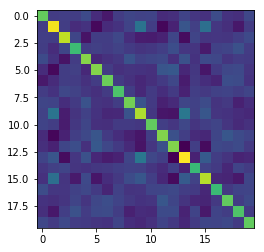

In [22]:
%matplotlib inline

cov = np.cov(als.VT)
plt.imshow(cov)

In [23]:
np.diag(cov)

array([ 0.08944496,  0.11974259,  0.10878299,  0.07857169,  0.09702205,
        0.09629579,  0.09103101,  0.0834988 ,  0.09279917,  0.10520002,
        0.08906699,  0.09576291,  0.09594417,  0.12237933,  0.07727521,
        0.10670002,  0.07796169,  0.08883993,  0.08398775,  0.08859226])

Learned components are independent.

In [24]:
als.means.mean()  # Global bias

3.2135887637940126

In [25]:
162 in i_test

False

In [26]:
users = list(i_test)
users.sort(key=lambda user_id: mangaki[user_id, :].getnnz())

In [27]:
len(users)

415

In [28]:
PIG = users[200]
# 162=JJ
pig = mangaki[PIG, :]
all_ratings = pig.data
#all_ratings -= als.means.mean()
pig.getnnz()

67

In [29]:
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression

ALPHA = 0.5

kernel = 1 * DotProduct(sigma_0=0.5)  # Kernel that will be used for both GP and DPP
gpr = GaussianProcessRegressor(kernel=kernel, alpha=ALPHA, optimizer=None, normalize_y=False)  # , optimizer=None
lr = LinearRegression()

In [30]:
work_ids = pig.indices[START_PRED:]
user_ids = [PIG] * len(work_ids)
y_pred = als.predict(np.column_stack((user_ids, work_ids)))
mean_squared_error(pig.data[START_PRED:], y_pred) ** 0.5

NameError: name 'START_PRED' is not defined

In [31]:
work_ids = pig.indices
ratings = pig.data
lr.fit(als.VT.T[work_ids], ratings)
y_pred = lr.predict(als.VT.T[work_ids])
mean_squared_error(pig.data, y_pred) ** 0.5

/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


NameError: name 'mean_squared_error' is not defined

In [32]:
pig.getnnz()

67

stupid has rmse 4.74105599422
0.372350843079
3.63445825548 to 1.05974876299


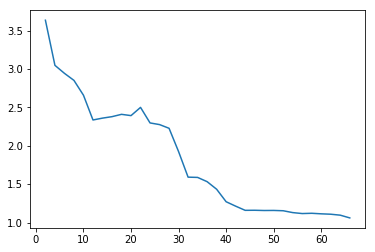

In [33]:
from sklearn.metrics import mean_squared_error

def fix(x):
    x[x > 6] = 6
    x[x < 1] = 1

START_PRED = 0
    
BATCH_SIZE = 2
steps = []
errors = []
print('stupid has rmse', mean_squared_error(pig.data[START_PRED:], [0.] * len(pig.data[START_PRED:])) ** 0.5)
for t in range(BATCH_SIZE, pig.getnnz() + 1, BATCH_SIZE):  # pig.getnnz() + 1
    steps.append(t)
    work_ids = pig.indices[:t]
    ratings = pig.data[:t]
    gpr.fit(als.VT.T[work_ids], ratings)
    y_pred, sigma = gpr.predict(als.VT.T[pig.indices[START_PRED:]], return_std=True)
    #fix(y_pred)
    rmse = mean_squared_error(pig.data[START_PRED:], y_pred) ** 0.5
    errors.append(rmse)
    #print(t, 'rmse', rmse)
    eig = np.linalg.eig(gpr.L_)[0]
    #print('eigenvalues', eig.min(), 'to', eig.max())
    #print('alpha max', gpr.alpha_.max())
    #print(y_pred[START_PRED:START_PRED+5], pig.data[START_PRED:START_PRED+5])
    #print(y_pred)
    lr.fit(als.VT.T[work_ids], ratings)
    y_pred = lr.predict(als.VT.T[pig.indices])
    rmse = mean_squared_error(pig.data, y_pred) ** 0.5
    #print(t, 'rmse', rmse)
    #print(y_pred[:5], pig.data[:5])
    #print(y_pred)
    #print(pig.data)
    #print(pig.indices[y_pred > 10])
print(sigma.mean())
print(max(errors), 'to', min(errors))
plt.plot(steps, errors)

In [34]:
# gpr.alpha_  # Learned weights for prediction

In [35]:
# gpr.kernel_  # Learned kernel, should not move

In [36]:
# np.diag(gpr.L_)  # Learned cholesky of kernel of train

(array([ 271.,   79.,   21.,   11.,   13.,    6.,    2.,    2.,    1.,
           4.,    1.,    0.,    1.,    1.,    2.]),
 array([  1.00000000e+00,   1.17000000e+02,   2.33000000e+02,
          3.49000000e+02,   4.65000000e+02,   5.81000000e+02,
          6.97000000e+02,   8.13000000e+02,   9.29000000e+02,
          1.04500000e+03,   1.16100000e+03,   1.27700000e+03,
          1.39300000e+03,   1.50900000e+03,   1.62500000e+03,
          1.74100000e+03]),
 <a list of 15 Patch objects>)

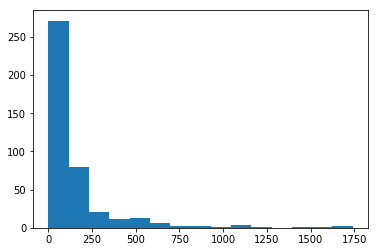

In [37]:
plt.hist([mangaki[user_id, :].getnnz() for user_id in i_test], 15)

## Linear kernel

In [38]:
len(pig.indices)

67

In [39]:
from mangaki.utils.dpp2 import MangakiDPP
from sklearn.gaussian_process.kernels import RBF

def prepare_dpp(rated):
    #rbf = RBF()
    #rated = als.VT.T[pig.indices]
    dpp = MangakiDPP(vectors=rated, REPEAT=5)
    #dpp.compute_similarity(kernel)
    dpp.L = kernel(rated) + ALPHA * np.eye(len(rated))
    #dpp.L = rbf(rated)# + np.eye(len(rated))
    dpp.preprocess()
    return dpp

In [40]:
inter = set(range(10086))
for user in users[390:500]:
    inter &= set(mangaki[user, :].indices)
print(len(inter))

10


In [41]:
inter = set(range(150))
c = []
for user in users[250:500]:
    c.append(len(set(mangaki[user, :].indices) & inter))
print(np.mean(c), 1.96 * np.std(c))

83.1333333333 65.4948751965


In [42]:
rated = als.VT.T[pig.indices]
dpp = prepare_dpp(rated)
dpp.sample_k(5)

array([29, 31, 59, 62, 65])

In [43]:
#all_vectors = als.VT.T[pig.indices]  # pig.indices
#all_vectors = als.VT.T[:25]

def bgs(rated, nb_questions_min):
    #global all_vectors
    nb_works = len(rated)
    rated_works = range(nb_works)  # pig.getnnz()
    #P = all_vectors[rated_works].dot(all_vectors[rated_works].T)
    P = kernel(rated) + ALPHA * np.eye(len(rated_works))
    # print(nb_works, nb_questions)
    kept_indices = set(range(nb_works))
    get_bgs = {len(kept_indices): np.array(list(kept_indices))}
    for _ in range(nb_works - nb_questions_min):
        k_best = None
        #error_min = float('inf')
        error_max = float('-inf')
        for k in kept_indices:
            kept = list(kept_indices - set([k]))
            try:
                #error = np.trace(np.linalg.inv(P[np.ix_(kept, kept)]))
                vp = np.abs(np.real(np.linalg.eig(P[np.ix_(kept, kept)])[0]))
                if type(vp[0]) == np.complex128:
                    print(vp)
                    raise Exception
                #error = hmean(vp)
                error = np.sum(np.log(vp))
                #print(error, vp[-1])
            except Exception as err:
                print('I had to take', nb_questions_min, 'but I must stop at', len(kept_indices))
                print(err)
                return list(kept_indices)
            #print(error)
            if error > error_max:#< error_min:
                #error_min = error
                error_max = error
                k_best = k
            '''if len(kept) <= 2 and random.random() < 0.1:
                print(kept, error, vp)'''
        kept_indices -= set([k_best])
        get_bgs[len(kept_indices)] = np.array(list(kept_indices))
    sampled_indices = list(kept_indices)
    return np.array(sampled_indices), get_bgs

In [44]:
_, get_bgs = bgs(rated, 2)

In [ ]:
# 90–250
# 250–415

In [94]:
for pos in [40, 90, 240, 250, 260, 340, 400, 405, len(users) - 1]:
    print(pos, mangaki[users[pos], :].getnnz())
print(len(users), 'users')

40 5
90 20
240 89
250 100
260 112
340 212
400 679
405 989
414 1741
415 users


In [79]:
popular = als.VT.T[:500]
popular_dpp = prepare_dpp(popular)

In [86]:
from datetime import datetime
TEST = 1000
start = datetime.now()
np.linalg.eig(np.random.random((TEST, TEST)))
print(datetime.now() - start)

0:00:01.296691


250 100
251 102
252 102


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


253 103
254 104
255 107
256 108
257 108
258 109
259 111
260 112
261 112
262 113
263 114
264 114
265 114
266 115
267 116
268 116
269 116
270 116
271 117
272 119
273 119
274 119
275 120
276 120
277 123
278 123
279 124
280 128
281 128
282 128
283 128
284 128
285 128
286 130
287 132
288 133
289 133
290 134
291 134
292 134
293 135
294 135
295 140
296 142
297 144
298 145
299 145
300 146
301 146
302 146
303 148
304 150
305 153
306 153
307 160
308 161
309 163
310 163
311 171
312 171
313 172
314 173
315 174
316 177
317 179
318 181
319 184
320 185
321 185
322 185
323 186
324 186
325 186
326 186
327 187
328 189
329 193
330 197
331 200
332 201
333 203
334 206
335 208
336 210
337 210
338 211
339 212
340 212
341 214
342 217
343 219
344 219
345 224
346 226
347 227
348 227
349 229
350 233
351 233
352 238
353 239
354 241
355 246
356 250
357 255
358 260
359 260
360 266
361 276
362 285
363 291
364 300
365 304
366 306
367 319
368 332
369 333
370 335
371 351
372 358
373 370
374 375
375 392
376 402
377 408


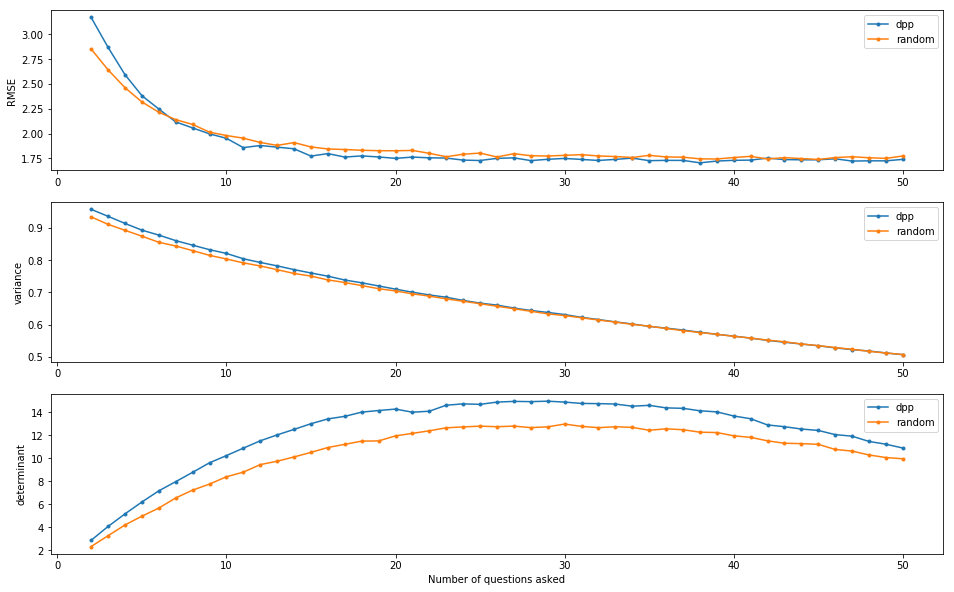

In [106]:
import random
from collections import defaultdict

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

STRATEGIES = ['dpp', 'random'] # , ':'bgs', 
LIMIT_SAMPLE = 2000
LIMIT_ASK = 50
USER_POS_LIMIT = 500

values = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for user_pos in range(250, 405):
    pig = mangaki[users[user_pos], :]
    #pig.data -= als.means.mean()  # Renormalize
    nb_total_rated = min(pig.getnnz(), LIMIT_SAMPLE)
    if user_pos % 1 == 0:
        print(user_pos, nb_total_rated)
    rated = als.VT.T[pig.indices[:LIMIT_SAMPLE]]  # LIMIT_SAMPLE is the limit
    if user_pos <= USER_POS_LIMIT:
        dpp = prepare_dpp(rated)  # DPP
        #_, get_bgs = bgs(rated, 1)  # BGS
    sizes = range(2, min(nb_total_rated, LIMIT_ASK) + 1)
    for nb_rated in sizes:
        for strategy in STRATEGIES:
            if strategy == 'random':
                pos = random.sample(range(nb_total_rated), nb_rated)
                work_ids = pig.indices[pos]
            elif strategy == 'dpp':
                if user_pos <= USER_POS_LIMIT:
                    pos = dpp.sample_k(nb_rated)
                    work_ids = pig.indices[pos]
                else:
                    pop = popular_dpp.sample_k(nb_rated)
                    askable = list(set(pop) & set(pig.indices))
                    if len(askable) < nb_rated:
                        remaining = nb_rated - len(askable)
                        #print(pos, 'oops', remaining, nb_rated)
                        askable.extend(random.sample(set(pig.indices) - set(askable), remaining))
                    work_ids = askable
            else:
                pos = get_bgs[nb_rated]
                work_ids = pig.indices[pos]
            ratings = pig[:, work_ids].data

            X_asked = als.VT.T[work_ids]
            values['det'][strategy][nb_rated].append(np.log(np.linalg.det(kernel(X_asked) + ALPHA * np.eye(nb_rated))))

            #print(work_ids.shape, X_asked.shape, ratings.shape)
            gpr.fit(X_asked, ratings)
            y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
            #fix(y_pred)
            rmse = mean_squared_error(pig.data, y_pred) ** 0.5
            #rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
            #rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
            values['sigma'][strategy][nb_rated].append(sigma.mean())
            #values['sigma_err'][strategy][nb_rated].append(1.96 * sigma.std())
            values['rmse'][strategy][nb_rated].append(rmse)
            #values['rmse_up'][strategy].append(rmse_up)
            #values['rmse_down'][strategy].append(rmse_down)
            #print(nb_rated, strategy, 'rmse', rmse)
            #print(y_pred[:5], pig.data[:5])

curves = defaultdict(list)
for strategy in STRATEGIES:
    for value in ['sigma', 'rmse', 'det']:
        mean = [np.mean(values[value][strategy][nb_rated]) for nb_rated in sizes]
        std = [np.std(values[value][strategy][nb_rated]) for nb_rated in sizes]
        curves[value].append(plot[value].errorbar(sizes, mean, label=strategy, fmt='.-'))  # , yerr=1.96 * np.array(std)
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

In [1]:
import pickle

backup = {}
for value in values:
    backup[value] = {}
    for strategy in STRATEGIES:
        backup[value][strategy] = {}
        for nb_rated in sizes:
            backup[value][strategy][nb_rated] = values[value][strategy][nb_rated]

'''with open('linear250-405-no-limit.pickle', 'wb') as f:
    pickle.dump(backup, f)'''

NameError: name 'values' is not defined

In [19]:
#with open('linear250-405-no-limit.pickle', 'rb') as f:
with open('linear90-250.pickle', 'rb') as f:
    backup2 = pickle.load(f)

len(backup2)

3

In [21]:
import numpy as np

import matplotlib
matplotlib.use('pgf')
pgf_with_rc_fonts = {
    'font.family': 'serif',
    'font.serif': [],
    'text.usetex': True,
    'text.latex.unicode': True,
}
matplotlib.rcParams.update(pgf_with_rc_fonts)
import matplotlib.pyplot as plt

subsizes = range(10, 40)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

STRATEGIES = ['dpp', 'random', 'bgs'] # , ':'bgs', 

from collections import defaultdict
curves = defaultdict(list)
for strategy in STRATEGIES:
    for value in ['sigma', 'rmse', 'det']:
        mean = [np.mean(backup2[value][strategy][nb_rated]) for nb_rated in subsizes]
        print(np.mean(mean))
        std = [np.std(backup2[value][strategy][nb_rated]) for nb_rated in subsizes] if strategy != 'random' else [0.] * len(subsizes)
        curves[value].append(plot[value].errorbar(subsizes, mean, label=strategy, fmt='.-'))  # yerr=1.96 * np.array(std)
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

plt.savefig('linear90-250.pdf', format='pdf')

0.631925981086
1.6346394227
11.5856229339
0.655964159586
1.64114222751
10.2724631087
0.582901527231
1.69682471115
14.7479662844


In [1066]:
P = np.random.random((5, 2))

In [1067]:
_, sigma, _ = np.linalg.svd(P)

In [1068]:
sigma ** 2

array([ 2.75481025,  0.24023893])

In [1070]:
np.linalg.svd(P.dot(P.T))

(array([[-0.6921513 ,  0.61451124,  0.17817563,  0.26389984, -0.20472623],
        [-0.20591154, -0.31782178,  0.63565118, -0.54018261, -0.40092404],
        [-0.20363248, -0.22904383, -0.66783424, -0.07297943, -0.67434722],
        [-0.28935687,  0.2371035 , -0.34228285, -0.74879228,  0.42685725],
        [-0.59441856, -0.6424065 , -0.03226308,  0.26933948,  0.40049445]]),
 array([  2.75481025e+00,   2.40238935e-01,   5.85678773e-17,
          3.30167623e-17,   5.02983733e-18]),
 array([[-0.6921513 , -0.20591154, -0.20363248, -0.28935687, -0.59441856],
        [ 0.61451124, -0.31782178, -0.22904383,  0.2371035 , -0.6424065 ],
        [ 0.35382594, -0.19257944,  0.00345917, -0.91015434,  0.09657884],
        [ 0.10187211,  0.75202175, -0.62990142, -0.13240423, -0.09888724],
        [-0.08793059, -0.5039506 , -0.71364204,  0.1189232 ,  0.46354537]]))

In [1072]:
np.linalg.svd(P[[1, 2, 4], :])[1]

array([ 1.15700538,  0.04186263])

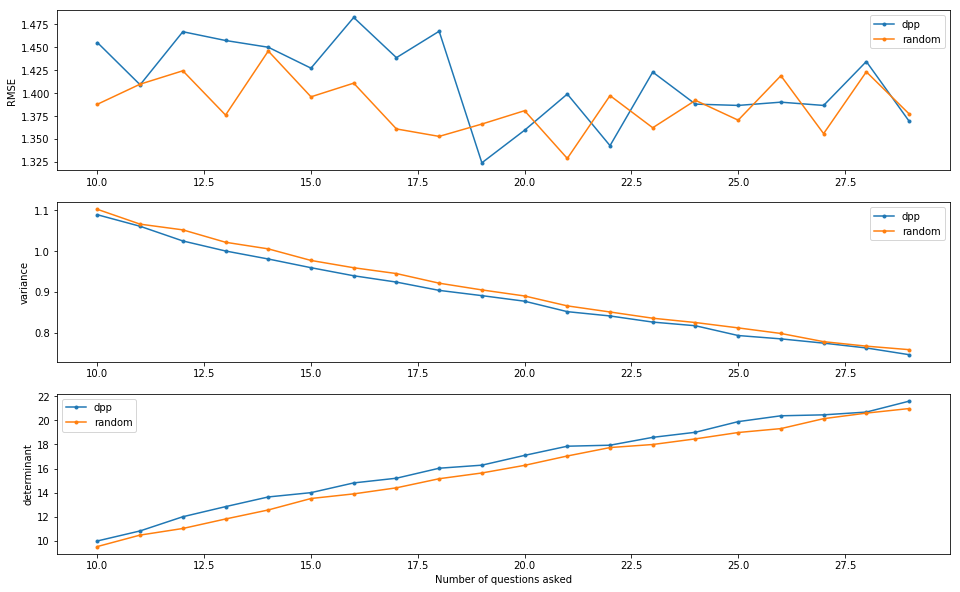

In [1046]:
subsizes = range(10, 30)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

curves = defaultdict(list)
for strategy in STRATEGIES:
    for value in ['sigma', 'rmse', 'det']:
        mean = [np.mean(values[value][strategy][nb_rated]) for nb_rated in subsizes]
        std = [np.std(values[value][strategy][nb_rated]) for nb_rated in subsizes] if strategy != 'random' else [0.] * len(subsizes)
        curves[value].append(plot[value].errorbar(subsizes, mean, label=strategy, fmt='.-'))  # 
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

In [769]:
from itertools import combinations

P = kernel(all_vectors) + 0.5 * np.eye(len(all_vectors))
det_max = 0.
best_subset = None
for subset in combinations(range(49), 3):
    vp = np.linalg.eig(P[np.ix_(subset, subset)])[0]
    det = np.sum(np.log(vp))
    if det > det_max:
        det_max = det
        best_subset = subset
print(best_subset, det_max)

(8, 18, 48) 4.25460508524


In [763]:
nb_rated = 3
rnd_ids = lambda: random.sample(range(total_rated), nb_rated)
bgs_ids = get_bgs[nb_rated]
dpp_ids = lambda: dpp.sample_k(nb_rated)

In [764]:
bgs_ids

array([ 8, 18, 48])

In [765]:
NB_SAMPLES = 10  # ('god', np.array(best_subset)), 
for strategy, pos in [('god', np.array(best_subset)), ('bgs', bgs_ids)] + [('dpp', dpp_ids()) for _ in range(NB_SAMPLES)] + [('rnd', rnd_ids()) for _ in range(NB_SAMPLES)]:
    cov = kernel(als.VT.T[pig.indices[pos]]) + 0.5 * np.eye(nb_rated)
    #plt.imshow(cov)
    print(strategy, np.linalg.det(cov), np.trace(cov), np.trace(np.linalg.inv(cov)))
    #plt.show()

god 70.428998245 12.9441472155 0.757048278569
bgs 70.428998245 12.9441472155 0.757048278569
dpp 39.6364976041 10.749006229 0.920698124954
dpp 47.5691573891 12.0751859134 0.913087202165
dpp 28.9860274404 9.97273072551 1.04952507028
dpp 40.4860914178 11.0070400776 0.925982264811
dpp 52.9832951942 12.2298801317 0.866642658198
dpp 37.6991738559 12.2264444503 1.04461854464
dpp 37.2510220756 10.4558451907 0.93358365863
dpp 40.7199820761 10.6882025798 0.907200112806
dpp 32.615762504 9.82940546514 0.960959078829
dpp 38.6342799324 10.645916851 0.930801676432
rnd 13.5096342561 7.74426304244 1.35266112668
rnd 23.1677988068 9.62566559232 1.16302997412
rnd 17.2154364862 8.02089401437 1.20499127812
rnd 19.3745770673 8.53273213737 1.17739386033
rnd 31.005674663 10.2495882414 1.05029142943
rnd 10.0599828581 6.84954391492 1.46142696033
rnd 25.5118832817 9.82916640679 1.12204069636
rnd 23.9830055827 9.12229113671 1.09664290944
rnd 13.7155963789 8.00250932112 1.42226032884
rnd 14.6027854875 7.54182922008

In [766]:
pig.indices[rand_ids][9], pig.indices[rand_ids][11]

IndexError: index 151 is out of bounds for axis 1 with size 49

## RBF kernel

In [62]:
from sklearn.gaussian_process.kernels import RBF

In [63]:
rated = als.VT.T[pig.indices]
rbf = RBF()
dpprbf = MangakiDPP(vectors=rated)
dpprbf.L = rbf(dpprbf.vectors)
dpprbf.preprocess()

1 random rmse 4.0760675024
[ 0.43073231  0.75149961  0.12702219  0.84212417  0.2416001 ] [ 2.  5.  5.  5.  2.]
1 dpp rmse 4.31876858209
[ 0.01080401  0.00523353  0.00710356  0.00542005  0.00369016] [ 2.  5.  5.  5.  2.]
1 bgs rmse 4.31876858209
[ 0.01080401  0.00523353  0.00710356  0.00542005  0.00369016] [ 2.  5.  5.  5.  2.]
3 random rmse 2.85355220442
[ 0.91758257  0.64655633  0.65725844  0.63852061  1.37689899] [ 2.  5.  5.  5.  2.]
3 dpp rmse 3.13322924277
[ 1.31573601  0.75988585  2.10841435  0.70437131  1.10721262] [ 2.  5.  5.  5.  2.]
3 bgs rmse 3.36993615636
[ 0.2354152   0.20935398  1.34020272  0.31890276  0.45048682] [ 2.  5.  5.  5.  2.]
5 random rmse 2.18597659959
[ 1.79369347  1.87698915  1.87755428  1.80654174  1.70334215] [ 2.  5.  5.  5.  2.]
5 dpp rmse 2.1476268852
[ 2.          5.          1.26127189  4.52129116  1.73523068] [ 2.  5.  5.  5.  2.]
5 bgs rmse 2.78555258766
[ 0.52108681  0.56352772  1.51176309  0.80522764  1.08304059] [ 2.  5.  5.  5.  2.]
7 random rms

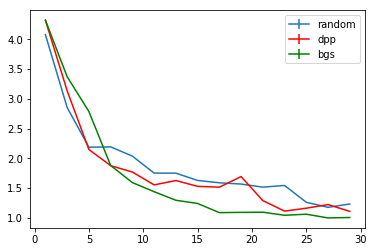

In [64]:
import random
from collections import defaultdict

kernel = DotProduct()
gpr = GaussianProcessRegressor()
BATCH_SIZE = 40
steps = []
errors = defaultdict(list)
errors_min = defaultdict(list)
errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in range(1, 30, 2):
    steps.append(nb_rated)
    for strategy in ['random', 'dpp', 'bgs']:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        elif strategy == 'dpp':
            pos = dpprbf.sample_k(nb_rated)
        elif strategy == 'bgs':
            pos = get_bgs[nb_rated]
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        
        gpr.fit(als.VT.T[work_ids], ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
        rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
        errors[strategy].append(rmse)
        errors_max[strategy].append(0)#abs(rmse_max - rmse))
        errors_min[strategy].append(0)#abs(rmse_min - rmse))
        print(nb_rated, strategy, 'rmse', rmse)
        print(y_pred[:5], pig.data[:5])
rand_curve = plt.errorbar(steps, errors['random'], yerr=[errors_min['random'], errors_max['random']], label='random')
dpp_curve = plt.errorbar(steps, errors['dpp'], yerr=[errors_min['dpp'], errors_max['dpp']], color='r', label='dpp')
bgs_curve = plt.errorbar(steps, errors['bgs'], yerr=[errors_min['bgs'], errors_max['bgs']], color='g', label='bgs')

plt.legend(handles=[rand_curve, dpp_curve, bgs_curve])
plt.show()

In [201]:
X = np.random.random((5, 2))*100
eig, _ = np.linalg.eig(X.dot(X.T))

In [204]:
np.round(eig)

array([ 18630.,     -0.,   3416.,      0.,     -0.])